In [65]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import shapely
import seaborn  as sns
from scipy.optimize import curve_fit
import tobler
import matplotlib
import networkx as nx
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import colors
from matplotlib import cm
import random
import pickle
import math
import ast
from shapely.geometry import Point, LineString
from scipy.spatial import cKDTree
from scipy.optimize import minimize
from scipy.integrate import odeint


In [66]:
import ast

In [67]:
from adjustText import adjust_text

In [68]:
from matplotlib.lines import Line2D

In [69]:
plt.rcParams.update({'font.size': 16})

#### Import Cassini map

In [70]:
edges=gpd.read_file("../Maps/edge/edge.shp")
edges=edges.set_crs("EPSG:2154")


In [71]:
nodes=gpd.read_file("../Maps/node/node.shp")
nodes=nodes.set_crs("EPSG:2154")


In [72]:
nodes1=nodes[nodes.component==1]

In [73]:
cities=nodes.dropna()

In [74]:
cities_joined=cities.dissolve(by="city_name").reset_index()

In [75]:
cities_joined.geometry=cities_joined.geometry.representative_point()

In [76]:
G_roads=nx.from_pandas_edgelist(edges, source='start_node', target='end_node', edge_attr="length")

In [77]:
pos = {row["node_id"]: (row["geometry"].x, row["geometry"].y) for _, row in nodes.iterrows()}

In [78]:
nx.set_node_attributes(G_roads, pos, "pos")

### Import transmission network

In [79]:
with open("../Data/G_tot.p", "rb") as f:
    G_tot = pickle.load(f)

In [16]:
#edges_to_remove = [(u, v) for u, v, attr in G_tot.edges(data=True) if attr.get('day', 0) < 27]

In [80]:
df_node_gf = pd.DataFrame.from_dict(dict(G_tot.nodes(data=True)), orient='index')

In [81]:
list_of_gf_towns=df_node_gf.name.to_list()

### Import Soissonais data

In [82]:
df=pd.read_csv("../Data/Rumor_Transmission_Soissonnais.csv")

In [83]:
df_origin=df[['Origin', 'Origin Date', 'origin_day', 'origin_time_min',
       'origin_time_max', 'Origin Date (readable)','origin (long;lat) ']]

In [84]:
df_dest=df[['Destination', 'arrival_day', 'arrival_time_min',
       'arrival_time_max', 'Arrival Date (readable)', 'arrival (long;lat)']]

In [85]:
df_link=df[['Origin', 'Destination', 'Arrival Date', 'Mode of Transmission',"mode",'arrival_day', 'arrival_time_min',
       'arrival_time_max',"Lefevbre"]]

In [86]:
df_link["time"]=(df_link["arrival_day"]-27)*24+(df_link["arrival_time_min"]+df_link["arrival_time_max"])/2-6

/var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/ipykernel_87068/2614320275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_link["time"]=(df_link["arrival_day"]-27)*24+(df_link["arrival_time_min"]+df_link["arrival_time_max"])/2-6


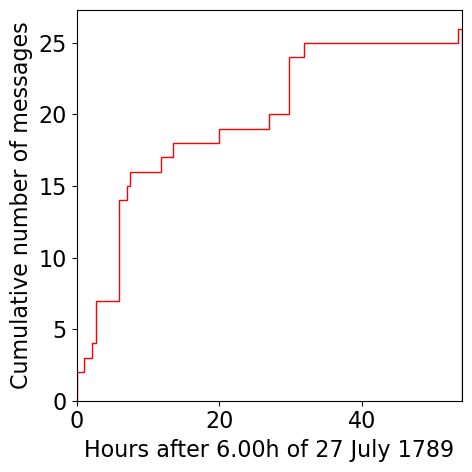

In [87]:
fig = plt.figure(figsize=(5,5))
df_link["time"].hist(cumulative=True,bins=100, histtype="step", color="red")
plt.xlim(0,54)
plt.ylabel("Cumulative number of messages")
plt.xlabel("Hours after 6.00h of 27 July 1789")
plt.grid(False)
plt.tight_layout()
plt.savefig("soisson_events.pdf")


In [88]:
# Convert the tuples into Point geometries (if the tuple is not NaN, create a Point)
df_dest['geometry'] = df_dest["arrival (long;lat)"].apply(
    lambda x: Point(map(float, x.split(','))) if pd.notnull(x) else None
)

/var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/ipykernel_87068/168661662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dest['geometry'] = df_dest["arrival (long;lat)"].apply(


In [89]:
# Convert the tuples into Point geometries (if the tuple is not NaN, create a Point)
df_origin['geometry'] = df_origin["origin (long;lat) "].apply(
    lambda x: Point(map(float, x.split(','))) if pd.notnull(x) else None
)

/var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/ipykernel_87068/742894557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_origin['geometry'] = df_origin["origin (long;lat) "].apply(


In [90]:
gdf_dest=gpd.GeoDataFrame(df_dest, geometry="geometry", crs="EPSG:4326")

In [91]:
gdf_dest=gdf_dest.to_crs("EPSG:2154")

In [92]:
gdf_origin=gpd.GeoDataFrame(df_origin, geometry="geometry", crs="EPSG:4326")

In [93]:
gdf_origin=gdf_origin.to_crs("EPSG:2154")

In [94]:
gdf_origin["pos"]=gdf_origin["geometry"].apply(lambda pt: pt.coords[0] if pt is not None else None)


In [95]:
gdf_dest["pos"]=gdf_dest["geometry"].apply(lambda pt: pt.coords[0] if pt is not None else None)


In [96]:
G=nx.from_pandas_edgelist(df_link, source='Origin', target='Destination', edge_attr=["Mode of Transmission","time","mode","Lefevbre"],create_using=nx.DiGraph())

In [97]:
dic1=dict(zip(gdf_origin["Origin"],gdf_origin['pos']))

In [98]:
dic2=dict(zip(gdf_dest["Destination"],gdf_dest['pos']))

In [99]:
nx.set_node_attributes(G, dic1, 'pos')

In [100]:
nx.set_node_attributes(G, dic2, 'pos')

In [101]:
df_link["mode"].unique()

array(['official', 'unofficial', 'unclear', 'mixed'], dtype=object)

In [102]:
# Extract all categories
categories = set(nx.get_edge_attributes(G, 'mode').values())
# Assign a unique color to each category
cmap = cm.get_cmap('Set1')  # good for categorical data
category_to_color = {cat: cmap(i) for i, cat in enumerate(categories)}


/var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/ipykernel_87068/2456515216.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set1')  # good for categorical data


In [103]:
# check which towns are in Lefevbre
for node, data in G.nodes(data=True):
    G.nodes[node]['GL'] = node in list_of_gf_towns


In [104]:
# Separate nodes by flag value
true_nodes = [n for n, d in G.nodes(data=True) if d.get('GL') is True]
false_nodes = [n for n, d in G.nodes(data=True) if d.get('GL') is False]


In [105]:
# Prepare node colors by flag
node_color_map = {
    True: 'orange',
    False: 'grey'
}
node_colors = [node_color_map[G.nodes[n]['GL']] for n in G.nodes()]

/var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/ipykernel_87068/1960447037.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=[category_to_color[category]], arrows=True, width=2)


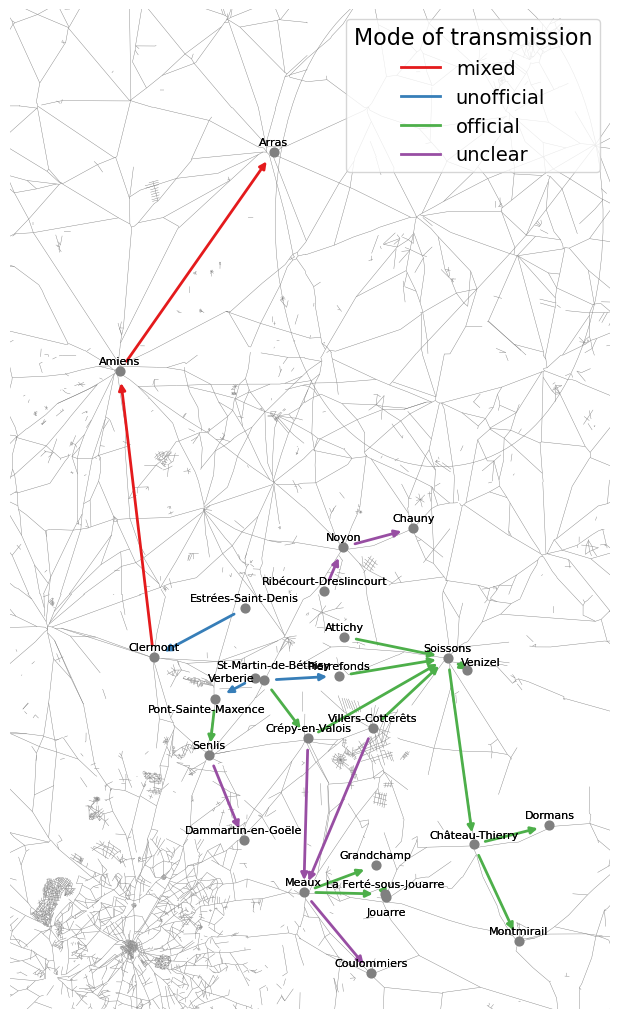

In [136]:
fig = plt.figure(figsize=(6,10))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
pos=nx.get_node_attributes(G, "pos")
nx.draw_networkx_edges(G_roads, pos=nx.get_node_attributes(G_roads, "pos"), edge_color="grey", width=0.3)
#gdf_roads.plot(ax=ax, color="green", lw=1, alpha=0.5)
nx.draw_networkx_nodes(G,  pos=pos, node_size=40, node_color="grey")
# Draw edges with colors based on the category
for u, v, data in G.edges(data=True):
    category = data['mode']
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=[category_to_color[category]], arrows=True, width=2)
# Draw edge if found in Lefevbre
#for u, v, data in G.edges(data=True):
#    if data['Lefevbre']=="Yes":
#        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color="black", arrows=False, width=1)
label_pos = {node: (coords[0], coords[1] + 2000) for node, coords in pos.items()}
node_to_move='Pont-Sainte-Maxence'
offset_x=-2000
offset_y=-2000
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='St-Martin-de-Béthisy'
offset_x=2000
offset_y=3000
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='Jouarre'
offset_x=0
offset_y=-3000
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='Verberie'
offset_x=-5500
offset_y=0
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='Venizel'
offset_x=3000
offset_y=1500
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
nx.draw_networkx_labels(G, label_pos, font_size=8)
nx.draw_networkx_labels(G, label_pos, font_size=8)
# Create legend
edge_legend = [
    Line2D([0], [0], color=category_to_color[cat], lw=2, label=cat)
    for cat in categories
]
plt.legend(handles=edge_legend, title="Mode of transmission", loc='upper right',fontsize=14,title_fontsize=16,
    frameon=True,
    facecolor='white')
plt.xlim(0.625e6,.76e6)
plt.ylim(6.85e6,7.05e6)
plt.savefig("soisson.pdf")

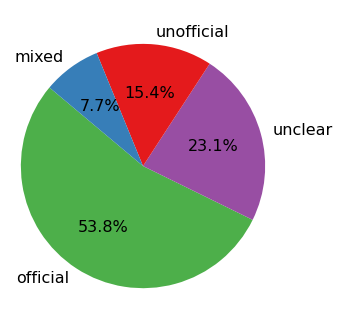

In [59]:

# Count the frequency of each category
counts = df['mode'].value_counts()
labels = counts.index
sizes = counts.values
cmap = cm.get_cmap('Set1')
colors = [(0.30196078431372547,
  0.6862745098039216,
  0.2901960784313726,
  1.0), (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0),
          (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745,
  1.0),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
  (0.30196078431372547,
  0.6862745098039216,
  0.2901960784313726,
  1.0)]
# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 16})
plt.axis('equal')  # Equal aspect ratio makes the pie a circle
plt.tight_layout()
plt.savefig("pie_char.pdf")
plt.show()

In [71]:
c=0
for u, v, data in G.edges(data=True): 
    if data['Lefevbre']=="Yes":
        c=c+1

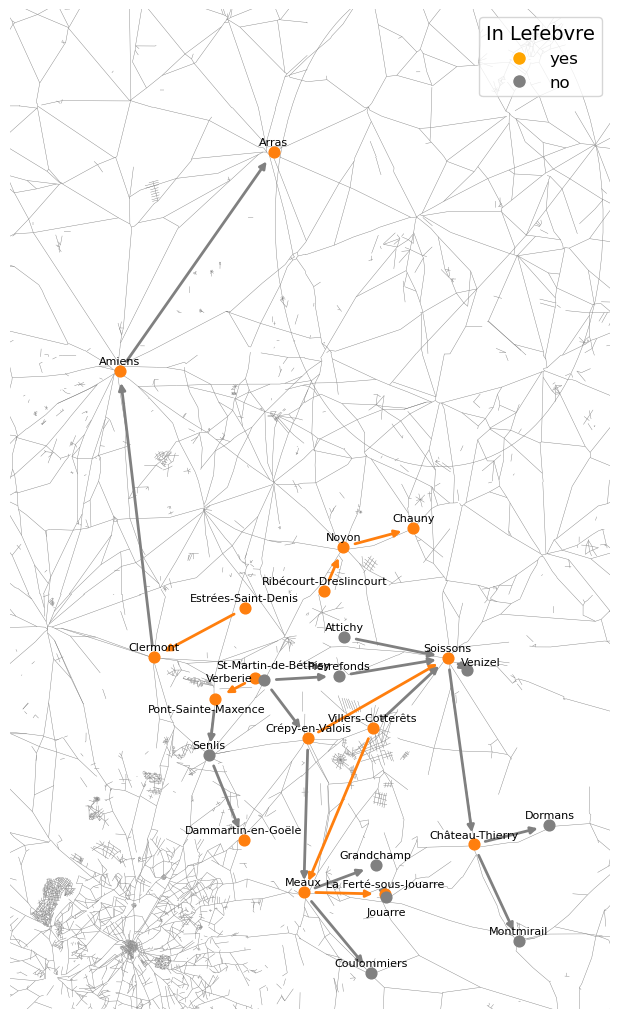

In [135]:
fig = plt.figure(figsize=(6,10))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
pos=nx.get_node_attributes(G, "pos")
nx.draw_networkx_edges(G_roads, pos=nx.get_node_attributes(G_roads, "pos"), edge_color="grey", width=0.3)
#gdf_roads.plot(ax=ax, color="green", lw=1, alpha=0.5)
nx.draw_networkx_nodes(G, nodelist=true_nodes, pos=pos, node_size=60, node_color="tab:orange")
nx.draw_networkx_nodes(G, nodelist=false_nodes, pos=pos, node_size=60, node_color="grey", label='not in Lefebvre')
# Draw edges with colors based on the category
for u, v, data in G.edges(data=True):   
    if data['Lefevbre']=="Yes":
        color="tab:orange"
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color, arrows=True, width=2)
    else: 
        color="grey"
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color, arrows=True, width=2)
label_pos = {node: (coords[0], coords[1] + 2000) for node, coords in pos.items()}
node_to_move='Pont-Sainte-Maxence'
offset_x=-2000
offset_y=-2000
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='St-Martin-de-Béthisy'
offset_x=2000
offset_y=3000
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='Jouarre'
offset_x=0
offset_y=-3000
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='Verberie'
offset_x=-6000
offset_y=0
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
node_to_move='Venizel'
offset_x=3000
offset_y=1500
label_pos[node_to_move] = (pos[node_to_move][0] + offset_x, pos[node_to_move][1] + offset_y)
nx.draw_networkx_labels(G, label_pos, font_size=8)
# Create legend
## Node legend (flag-based)
node_legend = [
    Line2D([0], [0], marker='o', color='w', label='yes',
           markerfacecolor=node_color_map[True], markersize=10),
    Line2D([0], [0], marker='o', color='w', label="no",
           markerfacecolor=node_color_map[False], markersize=10)
]

plt.legend(handles=node_legend, title="In Lefebvre", loc='upper right',fontsize=12,title_fontsize=14,
    frameon=True,
    facecolor='white')
plt.xlim(0.625e6,.76e6)
plt.ylim(6.85e6,7.05e6)
plt.savefig("soisson_GL.pdf")